<h1>Обучение нейронной сети на наборе данных MNIST

## Загрузка нужных библиотек

In [ ]:
#Фреймворк по работе с тензорами
import torch
#Пакет для создания моделей
import torch.nn as nn
#Пакет по настройки функций свертки
import torch.nn.functional as F
#Пакет для настройки оптимизатора
import torch.optim as optim
#torchvision Пакет состоит из популярных наборов данных,
#архитектур моделей и распространенных преобразований
#изображений для компьютерного зрения.
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR

# Установка CPU or GPU для обучения
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## Предварительная настройка

-в первом случае, количество
наблюдений (batch, партия) равно размеру датасета, веса не обновляются пока мы не пройдемся по всем наблюдениям, это простой градиентный спуск

-во втором случае, мы берем часть наблюдений (mini-batch, мини-партия), и когда обработаем их, то обновляем веса; после этого мы обрабатываем следующую партию

-и наконец мы можем взять только одно наблюдение и сразу после его анализа обновить веса, это классический стохастический градиентный спуск (stochastic gradient descent), параметр batch_size = 1

In [ ]:
seed = 42
torch.manual_seed(seed)

# Сохранить модель по окончанию?
save_model = False

# Размер партии обучающей и тестовой
batch_size = 64
test_batch_size = 14

# Количество эпох (по умолчанию 10)
n_epochs = 2

# Скорость обучения
learning_rate = 1.0


# Коэффициент снижения для корректировки скорости обучения
gamma = 0.7

# Сколько пакетов перед записью состояния обучения
log_interval = 10

# Количество классов цели в данных MNIST
num_classes = 10

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

# Настройки CUDA
if torch.cuda.is_available():
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

## Data preparation

Чаще всего данные центрируют — т.е. определяют, значение, которое станет новым 0 и “сдвигают” данные относительно него.


Что лучше взять за центр? Некоего «типичного представителя» Ваших данных. Так при использовании стандартизации используется среднее арифметическое значение.

In [ ]:
# Среднее и стандартное отклонение на основе
#масштабированных данных набора MNIST (предварительно рассчитанные)

data_mean = 0.1307
data_std = 0.3081

# Преобразование входных изображений в тензоры и нормализация
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_mean,), (data_std,))
])

# Получение данных MNIST из torchvision
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

# Определение загрузчиков данных, которые будут обрабатывать получение данных
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

## Прицип свертки в CNN (Свёрточная нейронная сеть)

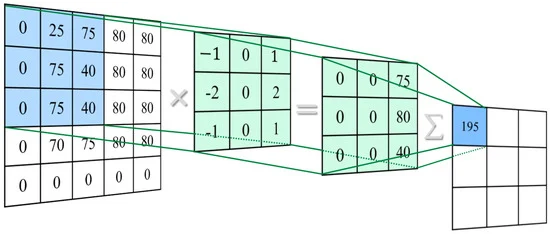

In [ ]:
# Define the architecture of the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2d( nn.1, 32, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='valid')
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

## Model training

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# Send the model to the device (CPU or GPU)
model = Net().to(device)

# Define the optimizer to user for gradient descent
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

# Shrinks the learning rate by gamma every step_size
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Train the model
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303437
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.190133
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.982814
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.953468
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.761265
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.802745
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.733097
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.738909
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.756195
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.757859
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.696007
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.692416
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.700961
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.692403
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.642780
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.682384
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.699099
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.596182
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.640822
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.612970
Train Epoch: 1 [12800/60000 (

In [ ]:
if save_model:
    torch.save(model.state_dict(), "mnist_cnn_pytorch.pt")